#### Librerias

In [2]:
import pandas as pd
import gzip
import networkx as nx
import pickle
from matplotlib.cm import ScalarMappable
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tarfile
import numpy as np
import textwrap

## Muestra de datos preprocesados por Santi:

#### Datos del building_id_count para un mes:

In [2]:
f = '../graphs/building_id_count.csv'
df1 = pd.read_csv(f, nrows=1000)  # Leer solo las primeras 1000 filas

print("Muestra de datos del building_id_count para un mes:")
df1.head()

Muestra de datos del building_id_count para un mes:


,building_id,cantidad
0,1361,33 OK
1,84,26 OK
2,839,24 OK
3,814,24 OK
4,67,22 OK


#### Datos del from_mac_hexa_to_building_id para un mes:

In [3]:
f = '../graphs/from_mac_hexa_to_building_id.csv'
df1 = pd.read_csv(f, nrows=1000)  # Leer solo las primeras 1000 filas

print("Muestra de datos del from_mac_hexa_to_building_id para un mes:")
df1.head()

Muestra de datos del from_mac_hexa_to_building_id para un mes:


,MAC_AP_hexa,building_id
0,00:35:1A:05:9A:00,891
1,00:35:1A:05:EF:D0,1318
2,00:35:1A:05:F4:C0,1052
3,00:35:1A:05:F6:60,1308
4,00:35:1A:05:F7:80,1406


## Muestra de datos del datos_APs_Abril.csv.gz y un grafo:

In [4]:
with gzip.open('../datos_ceibal/datos_resto_del_anio/datos_vecinos_Abril.csv.gz', 'rt') as f:
    df = pd.read_csv(f, nrows=1000)  # Leer solo las primeras 1000 filas

print("Muestra de datos:")
df.head(20)

FileNotFoundError: [Errno 2] No such file or directory: '../datos_ceibal/datos_resto_del_anio/datos_vecinos_Abril.csv.gz'

In [5]:
df['Banda'].nunique()

NameError: name 'df' is not defined

#### Ploteo de la potencia para los datos de Abril

In [ ]:
plt.figure(figsize=(15, 6))
df['Tx_power'].hist(bins=20, color='purple', edgecolor='black')
plt.title('Distribución de Potencia de Transmisión (Tx Power) - Abril')
plt.xlabel('Tx Power (dBm)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5)
plt.show()

### Visualización de un grafo de Abril para el edificio 6:

In [10]:
with open('../graphs/2_4_990/list_2_4_graphs_990_abril.pkl', 'rb') as f:  # Ejemplo para abril
    G = pickle.load(f)[0]  # Carga el primer grafo del mes

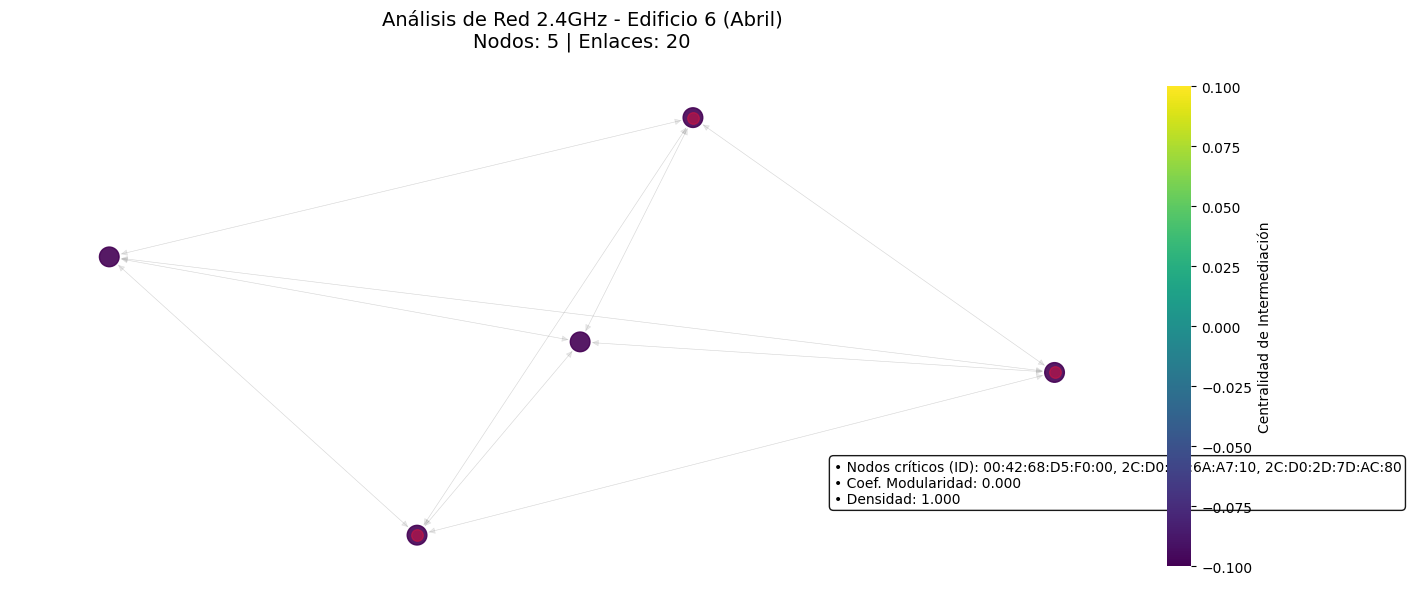

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))

# Calcular métricas clave
degree = dict(G.degree())
betweenness = nx.betweenness_centrality(G)
communities = nx.community.greedy_modularity_communities(G)

# Configurar colores y normalización
cmap = plt.cm.viridis
node_colors = [betweenness[n] for n in G.nodes()]
norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))

# Layout optimizado
pos = nx.spring_layout(G, k=0.2, seed=42, iterations=50)

# Dibujar componentes
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=[v * 25 for v in degree.values()],
    node_color=node_colors,
    cmap=cmap,
    alpha=0.9,
    ax=ax
)

edges = nx.draw_networkx_edges(
    G, pos,
    width=0.4,
    alpha=0.15,
    edge_color='dimgrey',
    ax=ax
)

# Destacar nodos importantes
top_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:3]
nx.draw_networkx_nodes(G, pos, nodelist=[n[0] for n in top_nodes], 
                       node_size=70, node_color='crimson', alpha=0.5, ax=ax)

# Barra de color profesional
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.95, label='Centralidad de Intermediación', pad=0.01)
cbar.outline.set_visible(False)

# Anotaciones mejoradas
ax.set_title(f"Análisis de Red 2.4GHz - Edificio 6 (Abril)\nNodos: {len(G.nodes())} | Enlaces: {len(G.edges())}",
             fontsize=14, pad=20)

info_text = f"""• Nodos críticos (ID): {', '.join([str(n[0]) for n in top_nodes])}
• Coef. Modularidad: {nx.community.modularity(G, communities):.3f}
• Densidad: {nx.density(G):.3f}"""
ax.text(0.72, 0.15, info_text,
        transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        fontsize=10)

ax.axis('off')
plt.tight_layout()
plt.show()

### **Comentarios generales** sobre el grafo anterior:


**Nodos (puntos circulares grandes)**

   * Hay **20 nodos**
   * El **tamaño y color del nodo** indican qué tan importante es ese nodo en la red.
   * Hay **313 enlaces**, lo que significa que los dispositivos están muy conectados entre sí.

**Color de los nodos (escala de colores)**

   **Centralidad de intermediación:**.
     Esto indica **qué tan crucial es un nodo para conectar a otros**.

      Nodos más amarillos = más importantes.
      Nodos azules o violetas = menos importantes en términos de conexión.

**Nodos críticos (círculo rojo)**

   * Los que tienen un borde rojo son nodos **críticos**. Si fallan, podrían afectar fuertemente la red:
     ```
     F4:CF:E2:66:F4:E0
     F4:CF:E2:17:59:10
     F4:CF:E2:54:33:10
     ```

---

 **Métricas que se muestran:**

**Coef. de Modularidad: 0.075**

   * Indica si hay "grupitos" dentro de la red.
     Un valor bajo (como este) dice que la red **no está bien dividida en comunidades** — es decir, **todo está muy conectado entre sí.**

**Densidad: 0.824**

   * Densidad = qué tan completa está la red.
     1.0 sería todos conectados con todos.
     0.824 es **muy denso**, lo cual implica que **la mayoría de los nodos están conectados entre sí**.

**Conclusiones del análisis:**

Red de Abril extremadamente densa (densidad = 0.824)

Solapamiento de señales, lo que puede causar interferencias.

Nodos críticos detectados por centralidad de intermediación

Los nodos con alta centralidad son potenciales cuellos de botella.

Ajustar su frecuencia para evitar saturación o reforzar sus rutas puede mejorar la eficiencia global.

## Muestra de datos del datos_filtrados_APs_Agosto.csv.gz y un grafo:

In [ ]:
with gzip.open('../datos_ceibal/datos_resto_del_anio/datos_filtrados_APs_Agosto.csv.gz', 'rt') as f:
    df1 = pd.read_csv(f, nrows=1000)  # Leer solo las primeras 1000 filas

print("Muestra de datos:")
df1.head()

Muestra de datos:


,Unnamed: 0,timestamp,LOCAL,MAC_AP,MAC_AP_hexa,AP_name,WLC,Banda,Canal,Power_level,Modelo,Tx_power
0,0,2018-08-01 01:14:19,1111063,0.53.26.5.154.0,00:35:1A:05:9A:00,1111063_Ci2_172.24.92.229,WLC1,0.0,11.0,4.0,"""AIR-CAP2702I-A-K9""",13.0
1,1,2018-08-01 01:14:19,1111063,0.53.26.5.154.0,00:35:1A:05:9A:00,1111063_Ci2_172.24.92.229,WLC1,1.0,149.0,1.0,"""AIR-CAP2702I-A-K9""",23.0
2,2,2018-08-01 01:14:19,1105072,0.53.26.5.239.208,00:35:1A:05:EF:D0,1105072_Ci3_172.28.158.4,WLC1,0.0,11.0,4.0,"""AIR-CAP2702I-A-K9""",13.0
3,3,2018-08-01 01:14:19,1105072,0.53.26.5.239.208,00:35:1A:05:EF:D0,1105072_Ci3_172.28.158.4,WLC1,1.0,44.0,1.0,"""AIR-CAP2702I-A-K9""",15.0
4,4,2018-08-01 01:14:19,1103285,0.53.26.5.244.192,00:35:1A:05:F4:C0,1103285_Ci2_172.24.116.101,WLC1,0.0,11.0,4.0,"""AIR-CAP2702I-A-K9""",13.0


In [82]:
tabla_mapeo = df1[['Power_level', 'Banda', 'Tx_power']].drop_duplicates().sort_values(by=['Power_level', 'Banda'])
print(tabla_mapeo.to_string(index=False))

 Power_level  Banda  Tx_power
         1.0    0.0      22.0
         1.0    1.0      23.0
         1.0    1.0      15.0
         1.0    1.0      17.0
         1.0    1.0      22.0
         1.0    1.0      11.0
         2.0    1.0      20.0
         2.0    1.0      12.0
         2.0    1.0      19.0
         2.0    1.0      14.0
         3.0    1.0      17.0
         3.0    1.0       9.0
         3.0    1.0      16.0
         3.0    1.0      11.0
         4.0    0.0      13.0
         4.0    1.0      13.0
         5.0    0.0      10.0
         5.0    1.0      10.0
         6.0    0.0       7.0
         6.0    1.0       8.0
         7.0    0.0       4.0
         8.0    0.0       1.0


#### Ploteo de la potencia para los datos de Abril

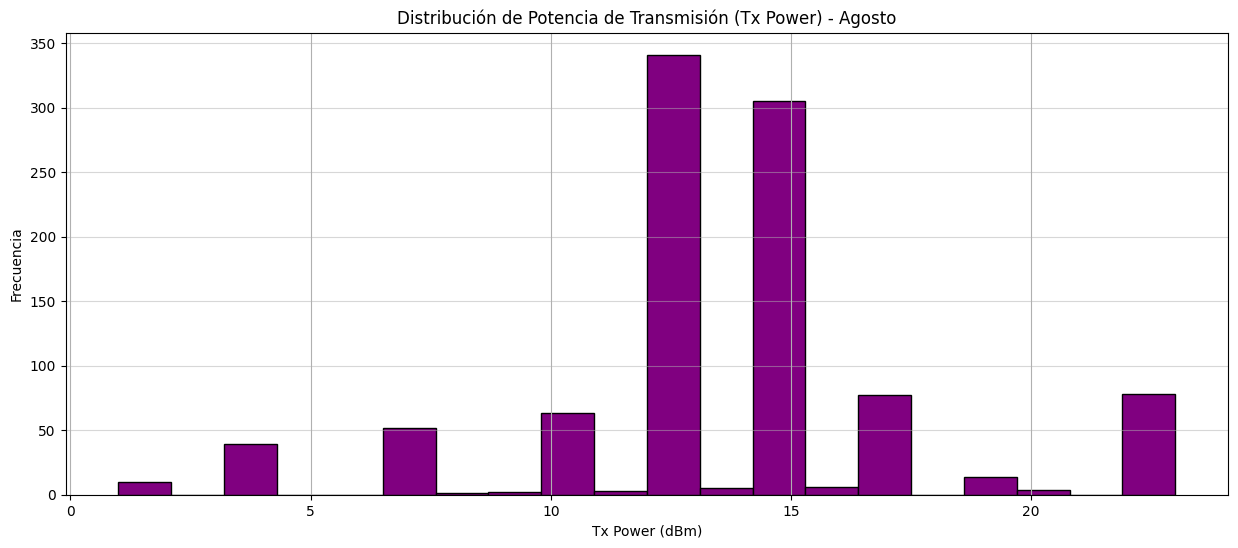

In [ ]:
plt.figure(figsize=(15, 6))
df1['Tx_power'].hist(bins=20, color='purple', edgecolor='black')
plt.title('Distribución de Potencia de Transmisión (Tx Power) - Agosto')
plt.xlabel('Tx Power (dBm)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5)
plt.show()

### Visualización de un grafo de Agosto para el edificio 994:

In [3]:
with open('../graphs/2_4_856/list_2_4_graphs_856_agosto.pkl', 'rb') as f:  # Ejemplo para agosto
    G = pickle.load(f)[0]  # Carga el primer grafo del mes


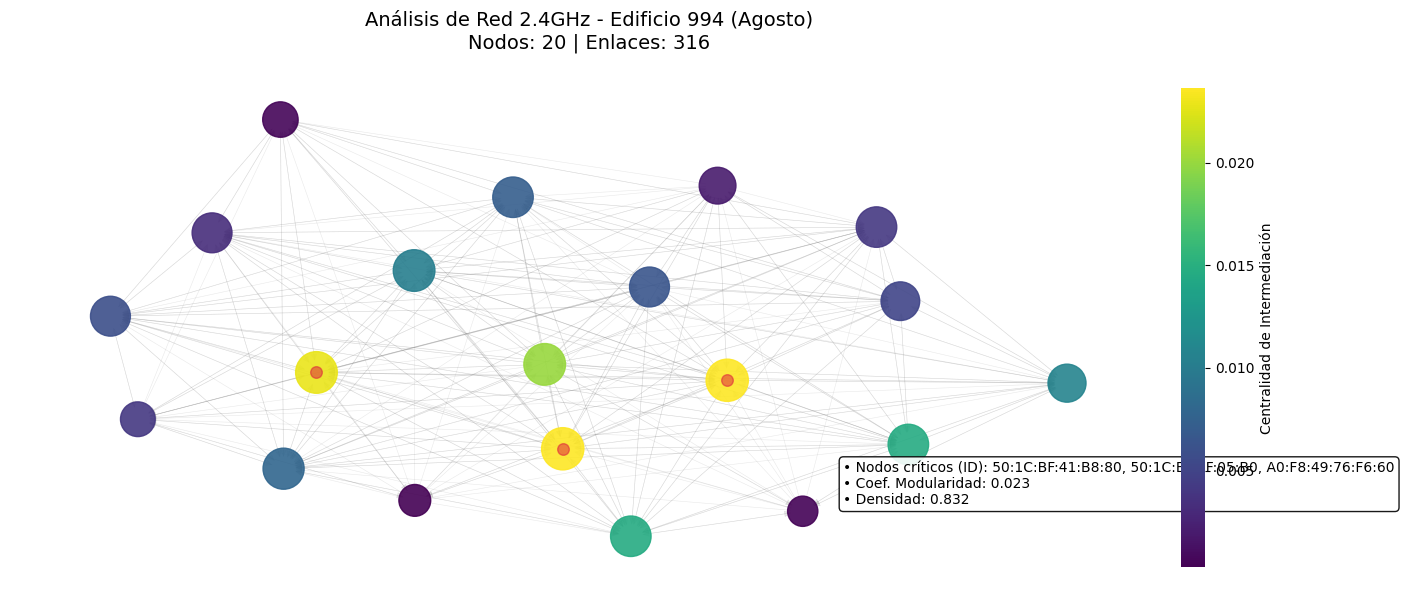

In [4]:
fig, ax = plt.subplots(figsize=(15, 6))

# Calcular métricas clave
degree = dict(G.degree())
betweenness = nx.betweenness_centrality(G)
communities = nx.community.greedy_modularity_communities(G)

# Configurar colores y normalización
cmap = plt.cm.viridis
node_colors = [betweenness[n] for n in G.nodes()]
norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))

# Layout optimizado
pos = nx.spring_layout(G, k=0.2, seed=42, iterations=50)

# Dibujar componentes
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=[v * 25 for v in degree.values()],
    node_color=node_colors,
    cmap=cmap,
    alpha=0.9,
    ax=ax
)

edges = nx.draw_networkx_edges(
    G, pos,
    width=0.4,
    alpha=0.15,
    edge_color='dimgrey',
    ax=ax
)

# Destacar nodos importantes
top_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:3]
nx.draw_networkx_nodes(G, pos, nodelist=[n[0] for n in top_nodes], 
                       node_size=70, node_color='crimson', alpha=0.5, ax=ax)

# Barra de color profesional
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.95, label='Centralidad de Intermediación', pad=0.01)
cbar.outline.set_visible(False)

# Anotaciones mejoradas
ax.set_title(f"Análisis de Red 2.4GHz - Edificio 994 (Agosto)\nNodos: {len(G.nodes())} | Enlaces: {len(G.edges())}",
             fontsize=14, pad=20)

info_text = f"""• Nodos críticos (ID): {', '.join([str(n[0]) for n in top_nodes])}
• Coef. Modularidad: {nx.community.modularity(G, communities):.3f}
• Densidad: {nx.density(G):.3f}"""
ax.text(0.72, 0.15, info_text,
        transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        fontsize=10)

ax.axis('off')
plt.tight_layout()
plt.show()

In [51]:
list(G.nodes())

['1C:6A:7A:72:87:90',
 '00:E1:6D:C8:59:A0',
 '1C:6A:7A:B5:94:00',
 '28:C7:CE:54:BE:D0',
 '28:C7:CE:54:C0:10',
 '38:1C:1A:C4:DF:50',
 '38:1C:1A:D5:3A:D0',
 '88:1D:FC:A2:CF:60',
 'BC:67:1C:64:98:A0',
 '38:1C:1A:D5:30:40']

# Exploración con nuevos datos de Ceibal:

In [ ]:
import tarfile

archivo_tgz = '../datos_ceibal/datos_ceibal_clientes/RSSI_WLCs_2018-07-27_11_05.tgz'

with tarfile.open(archivo_tgz, 'r:gz') as tar:
    nombres_archivos = tar.getnames()

    for nombre in nombres_archivos:
        miembro = tar.getmember(nombre)
        f = tar.extractfile(miembro)
        if f is None:
            continue

        print(f'\nArchivo: {nombre}')
        for i, linea in enumerate(f):
            if i >= 3:
                break
            print(linea.decode('utf-8').strip())


Archivo: RSSI_WLCs/datos_ASOCIACION_WLC1.txt
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.109.6.33 = Hex-STRING: 1C 6A 7A B5 85 E0
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.109.44.237 = Hex-STRING: 18 8B 9D 83 2D D0
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.174.241.178 = Hex-STRING: 18 8B 9D 6E A1 C0

Archivo: RSSI_WLCs/datos_ASOCIACION_WLC3.txt
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.108.193.34 = Hex-STRING: 00 F2 8B E9 5F E0
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.108.212.112 = Hex-STRING: 28 6F 7F C9 D5 80
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.108.244.236 = Hex-STRING: 1C 6A 7A EB AF 70

Archivo: RSSI_WLCs/datos_RSSI_WLC1.txt
SNMPv2-SMI::enterprises.14179.2.1.11.1.5.0.0.6.109.6.33.24.139.157.86.96.80.0.0 = INTEGER: -87
SNMPv2-SMI::enterprises.14179.2.1.11.1.5.0.0.6.109.6.33.24.139.157.86.96.80.0.1 = INTEGER: -78
SNMPv2-SMI::enterprises.14179.2.1.11.1.5.0.0.6.109.6.33.24.139.157.131.37.128.0.0 = INTEGER: -92

Archivo: RSSI_WLCs/datos_RSSI_WLC3.txt
SNMPv2

### 🧩 Estructura de los datos

Los archivos contienen líneas con información SNMP (Simple Network Management Protocol) en formato de texto plano. Cada línea representa un valor de una variable SNMP, identificada por un OID (Object Identifier). Los valores pueden ser de tipo `Hex-STRING` o `INTEGER`.

Ejemplos:

* **Asociación de clientes (Hex-STRING):**

  ```
  SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.8.165.6.111 = Hex-STRING: 1C 6A 7A 7B D0 D0
  ```

Este OID corresponde a la dirección MAC de un cliente asociado al WLC.

* **Nivel de señal (RSSI) (INTEGER):**

  ```
  SNMPv2-SMI::enterprises.14179.2.1.11.1.5.0.0.8.165.6.111.0.66.104.110.190.128.0.0 = INTEGER: -80
  ```

Este OID representa el nivel de señal RSSI (Received Signal Strength Indicator) de un cliente conectado.

# Ejercicio:

Analizar si cada cliente WiFi está conectado al punto de acceso (AP) que le brinda la señal más fuerte. Para esto, se puede:

•⁠  ⁠Evaluar en una tabla si el AP al que está asociado cada cliente es efectivamente el que tiene mayor potencia de señal entre todos los que escucha.

•⁠  ⁠Representar gráficamente el edificio con las posiciones de los APs y clientes, indicando con pesos o colores la intensidad de señal para visualizar mejor los casos.

El objetivo es calcular qué porcentaje de clientes están conectados al AP con la señal más fuerte.

In [2]:
def extraer_mac(numeros):
    """Convierte lista de strings con números decimales a MAC en formato hexadecimal."""
    return ':'.join(f'{int(n):02x}' for n in numeros)

archivo_tgz = '../datos_ceibal/datos_ceibal_clientes/RSSI_WLCs_2018-07-27_11_05.tgz'

# Extraer string de fecha y convertirlo con pd.to_datetime
match_ts = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}_\d{2})', archivo_tgz)
timestamp_archivo = pd.to_datetime(match_ts.group(1), format='%Y-%m-%d_%H_%M') if match_ts else None


datos = []

with tarfile.open(archivo_tgz, 'r:gz') as tar:
    for nombre in tar.getnames():
        if 'datos_RSSI' not in nombre:
            continue

        # Buscar WLC (ej: WLC1, WLC2, etc.)
        wlc_match = re.search(r'(WLC\d+)', nombre)
        wlc_id = wlc_match.group(1) if wlc_match else None

        miembro = tar.getmember(nombre)
        f = tar.extractfile(miembro)
        if f is None:
            continue

        for linea in f:
            linea = linea.decode('utf-8').strip()
            match = re.search(r'1\.5\.(.*?) = INTEGER: (-?\d+)', linea)
            if not match:
                continue

            partes_oid = match.group(1).split('.')
            if len(partes_oid) < 12:
                continue

            mac_cliente = extraer_mac(partes_oid[0:6])
            mac_ap = extraer_mac(partes_oid[6:12])
            antena = int(partes_oid[12]) if len(partes_oid) > 12 else None
            banda = int(partes_oid[13]) if len(partes_oid) > 13 else None
            rssi = int(match.group(2))

            datos.append({
                'MAC_CLIENT': mac_cliente.lower(),
                'MAC_AP': mac_ap.lower(),
                'BANDA': banda,
                'ANTENA': antena,
                'RSSI': rssi,
                'WLC': wlc_id,
                'timestamp': timestamp_archivo
            })

df_rssi = pd.DataFrame(datos)
df_rssi['timestamp'] = df_rssi['timestamp'].dt.strftime('%Y-%m-%d %H:%M')


In [3]:
# Para mostrar las filas 100 a 199 de df_rssi, usa iloc:
df_rssi.iloc[190:200]

,MAC_CLIENT,MAC_AP,BANDA,ANTENA,RSSI,WLC,timestamp
190,00:08:22:1c:e9:04,18:8b:9d:36:92:a0,0,0,-86,WLC1,2018-07-27 11:05
191,00:08:22:1c:e9:04,18:8b:9d:36:92:a0,1,0,-92,WLC1,2018-07-27 11:05
192,00:08:22:1c:e9:04,18:8b:9d:56:43:b0,0,0,-77,WLC1,2018-07-27 11:05
193,00:08:22:1c:e9:04,18:8b:9d:56:43:b0,1,0,-79,WLC1,2018-07-27 11:05
194,00:08:22:1c:e9:04,18:8b:9d:56:43:b0,0,1,-88,WLC1,2018-07-27 11:05
195,00:08:22:1c:e9:04,18:8b:9d:56:43:b0,1,1,-89,WLC1,2018-07-27 11:05
196,00:08:22:1c:e9:04,18:8b:9d:56:44:80,0,0,-92,WLC1,2018-07-27 11:05
197,00:08:22:1c:e9:04,18:8b:9d:56:44:80,1,0,-90,WLC1,2018-07-27 11:05
198,00:08:22:1c:e9:04,18:8b:9d:56:45:40,0,0,-52,WLC1,2018-07-27 11:05
199,00:08:22:1c:e9:04,18:8b:9d:56:45:40,1,0,-58,WLC1,2018-07-27 11:05


In [4]:
filtro = (
    ((df_rssi['BANDA'] == 1) & (df_rssi['ANTENA'] == 1)))
cantidad = df_rssi[filtro].shape[0]
print(cantidad)

59695


In [5]:
df_mejor_rssi = df_rssi.loc[df_rssi.groupby('MAC_CLIENT')['RSSI'].idxmax()]

In [6]:
porcentaje_bandas = df_rssi['BANDA'].value_counts(normalize=True) * 100
print(porcentaje_bandas)

BANDA
0    50.003431
1    49.996569
Name: proportion, dtype: float64


In [23]:
# --------------------------------------------------------------------------------
# 3) Cargar datos de APs desde el CSV comprimido (.csv.gz)
# --------------------------------------------------------------------------------
ruta_aps = '../datos_ceibal/datos_resto_del_anio/datos_APs_Julio.csv.gz'
with gzip.open(ruta_aps, 'rt') as f:
    df_aps = pd.read_csv(f)

## Prueba con datos Santi:
Nos quedamos solo con los datos de APs que fueron recolectados el 27 de julio de 2018.

Creamos una nueva variable df_aps_day con esos datos.

In [24]:
# 3) Filtramos df_aps para quedarnos solo con el día 2018-07-27
#    Ajustá el rango si quisieras otro día u hora exacta
inicio = pd.to_datetime('2018-07-27 00:00')
fin    = pd.to_datetime('2018-07-27 23:59')
df_aps['timestamp'] = pd.to_datetime(df_aps['timestamp'])
df_aps_day = df_aps[(df_aps['timestamp'] >= inicio) & (df_aps['timestamp'] <= fin)].copy()
df_aps_day['timestamp'] = df_aps_day['timestamp'].dt.strftime('%Y-%m-%d %H:%M')


In [25]:
df_aps_day.head()

,Unnamed: 0,timestamp,WLC,MAC_AP,MAC_AP_hexa,Modelo,Banda,Canal,Tx_power,Power_level
10870963,10871514,2018-07-27 00:04,WLC1,0.53.26.5.154.0,00:35:1A:05:9A:00,"""AIR-CAP2702I-A-K9""",0,11.0,13.0,4.0
10870964,10871515,2018-07-27 00:04,WLC1,0.53.26.5.154.0,00:35:1A:05:9A:00,"""AIR-CAP2702I-A-K9""",1,149.0,23.0,1.0
10870965,10871516,2018-07-27 00:04,WLC1,0.53.26.5.239.208,00:35:1A:05:EF:D0,"""AIR-CAP2702I-A-K9""",0,11.0,13.0,4.0
10870966,10871517,2018-07-27 00:04,WLC1,0.53.26.5.239.208,00:35:1A:05:EF:D0,"""AIR-CAP2702I-A-K9""",1,44.0,15.0,1.0
10870967,10871518,2018-07-27 00:04,WLC1,0.53.26.5.244.192,00:35:1A:05:F4:C0,"""AIR-CAP2702I-A-K9""",0,11.0,7.0,6.0


#### ¿Que hacemos?
Convertimos las direcciones MAC a minúsculas y sin espacios extras para asegurar que se puedan comparar bien.\\

Aseguramos de que las columnas de banda sean tipo int, por si vienen como texto o float.

In [26]:
# 4) Normalizamos MAC_AP y Banda en ambos dataframes
df_rssi['MAC_AP'] = df_rssi['MAC_AP'].str.lower().str.strip()
df_rssi['BANDA']  = df_rssi['BANDA'].astype(int)

df_aps_day['MAC_AP_hexa'] = df_aps_day['MAC_AP_hexa'].str.lower().str.strip()
df_aps_day['Banda']       = df_aps_day['Banda'].astype(int)

#### ¿Que hacemos?

Eliminamos la columna de MAC en formato decimal (no sirve para el cruce).

Renombramos MAC_AP_hexa a simplemente MAC_AP para que coincida con la de df_rssi.

In [27]:
df_aps_day = df_aps_day.drop(columns=['MAC_AP'])
df_aps_day = df_aps_day.drop(columns=['Modelo'])
df_aps_day = df_aps_day.drop(columns=['Unnamed: 0'])
df_aps_day = df_aps_day.rename(columns={'MAC_AP_hexa': 'MAC_AP'})

## Ordenamos los datos por edificio:

Sacamos la correspondencia de mac_hexa_to_building_id y ordeno el df por edificio.

In [7]:
# 1) Carga tu mapping AP→building
mapping_path = '../graphs/from_mac_hexa_to_building_id.csv'
map_df = pd.read_csv(mapping_path, usecols=['MAC_AP_hexa', 'building_id'])
map_df = map_df.rename(columns={'MAC_AP_hexa': 'MAC_AP'})

# 2) Asegúrate de que las columnas tengan el mismo formato
#    Si tu df_rssi usa Mayúsculas/minúsculas distintas o sin separadores:
df_rssi['MAC_AP'] = df_rssi['MAC_AP'].str.lower()
map_df  ['MAC_AP'] = map_df ['MAC_AP'].str.lower()

# 4) Haz el merge (left para conservar todo df_rssi)
df_merged = df_rssi.merge(
    map_df,
    on='MAC_AP',
    how='left'    # usa 'inner' si solo quieres filas con building_id conocido
)

# 5) Comprueba cuántos quedaron sin building_id
n_missing = df_merged['building_id'].isna().sum()
print(f"Filas sin building_id asignado: {n_missing}")

# 7) Ordena por building_id y timestamp
df_merged = df_merged.sort_values(['building_id', 'timestamp']).reset_index(drop=True)


Filas sin building_id asignado: 3990


In [8]:
df_merged.head()

,MAC_CLIENT,MAC_AP,BANDA,ANTENA,RSSI,WLC,timestamp,building_id
0,00:21:43:94:5d:1c,f4:cf:e2:62:e6:50,0,0,-76,WLC1,2018-07-27 11:05,1.0
1,00:21:43:94:5d:1c,f4:cf:e2:62:e6:50,1,0,-80,WLC1,2018-07-27 11:05,1.0
2,00:21:43:be:eb:ed,f4:cf:e2:1c:f6:30,0,0,-71,WLC1,2018-07-27 11:05,1.0
3,00:21:43:be:eb:ed,f4:cf:e2:1c:f6:30,1,0,-70,WLC1,2018-07-27 11:05,1.0
4,00:21:43:be:eb:ed,f4:cf:e2:54:60:40,0,0,-77,WLC1,2018-07-27 11:05,1.0


## Mejor conexión Cliente-AP:

Para el edificio 994 se cuenta cuantas conexiones entre cliente-AP distintos hay

In [9]:
# 1) Filtrar solo el edificio 994
df_edif = df_merged[df_merged['building_id'] == 994]

# 2) Contar APs distintos por cliente
ap_counts = (
    df_edif
    .groupby('MAC_CLIENT')['MAC_AP']
    .nunique()
    .reset_index(name='num_APs')
)

# 4) Filtrar solo los clientes con más de un AP en ese edificio
clientes_multi_ap = ap_counts[ap_counts['num_APs'] > 1]
print("\nClientes con RSSI de más de un AP disponible en el edificio 994:")
print(clientes_multi_ap)



Clientes con RSSI de más de un AP disponible en el edificio 994:
           MAC_CLIENT  num_APs
0   00:21:43:d3:db:ce       10
1   00:80:92:c4:f5:18       10
2   14:6b:72:c8:4a:cc        7
3   3c:05:18:e1:42:8d        2
4   40:f0:2f:bf:3b:05       10
..                ...      ...
60  bc:b3:08:bc:86:b2       10
61  d8:c4:6a:8e:81:37       10
62  ec:d0:9f:aa:21:db        6
63  f4:42:8f:85:28:a1        9
64  f4:42:8f:a9:7b:18        5

[63 rows x 2 columns]


Se llega a la conclusión que tenemos para los clientes varios RSSI de diferentes AP's por lo tanto se procede a procesar los archivos Asociaciones para ver a que ap está conectado.

In [10]:
archivo_tgz = '../datos_ceibal/datos_ceibal_clientes/RSSI_WLCs_2018-07-27_11_05.tgz'

# Extraer timestamp del nombre del archivo tgz
match_ts = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}_\d{2})', archivo_tgz)
timestamp_archivo = pd.to_datetime(match_ts.group(1), format='%Y-%m-%d_%H_%M') if match_ts else None

datos = []

with tarfile.open(archivo_tgz, 'r:gz') as tar:
    for nombre in tar.getnames():
        if 'datos_ASOCIACION' not in nombre:
            continue

        # Buscar WLC (ej: WLC1, WLC2, etc.)
        wlc_match = re.search(r'(WLC\d+)', nombre)
        wlc_id = wlc_match.group(1) if wlc_match else None

        miembro = tar.getmember(nombre)
        f = tar.extractfile(miembro)
        if f is None:
            continue

        for linea in f:
            linea = linea.decode('utf-8').strip()
            match = re.search(r'\.4\.1\.4\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.(\d+) = Hex-STRING: ([0-9A-Fa-f ]+)', linea)
            if not match:
                continue
                
            # Extraer MAC cliente (6 números decimales)
            mac_cliente = extraer_mac(match.groups()[:6])
            
            # Extraer MAC AP del Hex-STRING
            mac_ap_hex = match.group(7).replace(' ', '')
            mac_ap = ':'.join([mac_ap_hex[i:i+2] for i in range(0, 12, 2)]).lower()
            
            datos.append({
                'MAC_CLIENT': mac_cliente.lower(),
                'MAC_AP': mac_ap.lower(),
                'WLC': wlc_id,
                'timestamp': timestamp_archivo
            })

df_asociacion = pd.DataFrame(datos)
if not df_asociacion.empty:
    df_asociacion['timestamp'] = df_asociacion['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

In [11]:
df_asociacion.head()

,MAC_CLIENT,MAC_AP,WLC,timestamp
0,00:00:06:6d:06:21,1c:6a:7a:b5:85:e0,WLC1,2018-07-27 11:05
1,00:00:06:6d:2c:ed,18:8b:9d:83:2d:d0,WLC1,2018-07-27 11:05
2,00:00:06:ae:f1:b2,18:8b:9d:6e:a1:c0,WLC1,2018-07-27 11:05
3,00:00:06:af:16:a8,00:42:68:d6:06:20,WLC1,2018-07-27 11:05
4,00:00:08:a4:95:aa,18:8b:9d:36:75:00,WLC1,2018-07-27 11:05


In [12]:
df_asociacion.shape[0]

63589

## Representaciones gráficas del grafo de un edificio

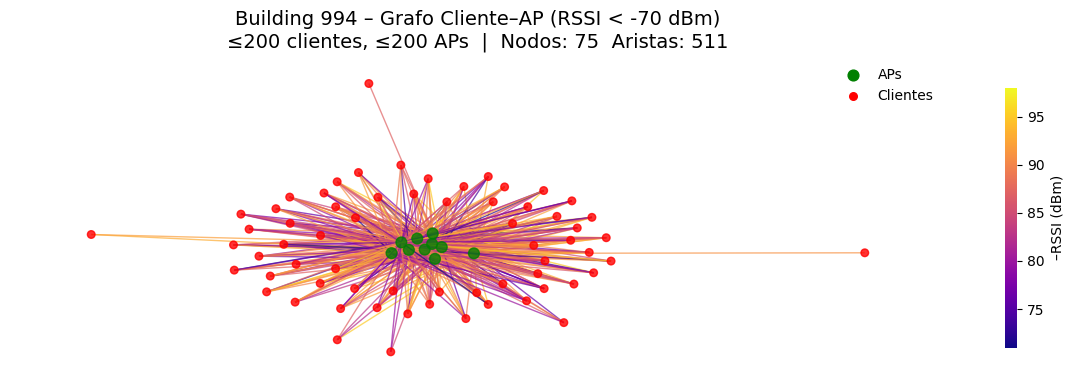

In [19]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

def build_and_draw_filtered_graph_by_building(
    df_rssi_with_building,
    building_id,
    threshold=70,
    b5G=False,
    max_clients=200,
    max_aps=200,
    random_state=42
):
    """
    - Filtra tu df_rssi que ya contiene la columna `building_id`.
    - Selecciona sólo las filas de `building_id` indicado.
    - Filtra RSSI < -threshold dBm.
    - Toma hasta `max_clients` clientes con enlaces y luego hasta `max_aps` APs con enlaces.
    - Elimina nodos aislados.
    - Dibuja el grafo bipartito resultante.
    - Exporta el grafo con la columna RSSI como atributo de las aristas.
    """
    # 1) Filtrar por edificio
    df = df_rssi_with_building[df_rssi_with_building['building_id'] == building_id].copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # 2) Filtrar banda y RSSI fuerte
    df = df[df['BANDA'] == (1 if b5G else 0)]
    df = df[df['RSSI'] < -threshold]

    # 3) Escoge un único timestamp (p.ej. el primero)
    ts = df['timestamp'].sort_values().iloc[0]
    sub = df[df['timestamp'] == ts]

    # 4) Muestreo de clientes con al menos un enlace
    clients = sub['MAC_CLIENT'].unique().tolist()
    if len(clients) > max_clients:
        clients = pd.Series(clients).sample(max_clients, random_state=random_state).tolist()
    sub = sub[sub['MAC_CLIENT'].isin(clients)]

    # 5) Muestreo de APs con al menos un enlace
    aps = sub['MAC_AP'].unique().tolist()
    if len(aps) > max_aps:
        aps = pd.Series(aps).sample(max_aps, random_state=random_state).tolist()
    sub = sub[sub['MAC_AP'].isin(aps)]

    # 6) Reconstruir listas finales (sin nodos aislados)
    clients = sub['MAC_CLIENT'].unique().tolist()
    aps     = sub['MAC_AP'].unique().tolist()

    # 7) Construir grafo bipartito con RSSI como atributo de arista
    G = nx.Graph()
    G.add_nodes_from(aps, bipartite='ap')
    G.add_nodes_from(clients, bipartite='client')
    for (c, a), grp in sub.groupby(['MAC_CLIENT', 'MAC_AP']):
        rssi_mean = grp['RSSI'].mean()
        G.add_edge(c, a, rssi=rssi_mean)

    # 📝 Exportar a GEXF con RSSI
    nx.write_gexf(G, f"Grafo_building_{building_id}.gexf")

    # 8) Preparar colores y tamaños
    ap_nodes     = {n for n, d in G.nodes(data=True) if d['bipartite'] == 'ap'}
    client_nodes = set(G.nodes()) - ap_nodes
    node_colors  = ['green' if n in ap_nodes else 'red' for n in G.nodes()]
    node_sizes   = [60 if n in ap_nodes else 30 for n in G.nodes()]

    # 9) Colores de aristas por –RSSI
    rssis = [-d['rssi'] for _, _, d in G.edges(data=True)]
    cmap, norm = plt.cm.plasma, plt.Normalize(vmin=min(rssis), vmax=max(rssis))

    # 10) Posicionamiento
    pos = nx.spring_layout(G, k=0.3, seed=random_state)

    # 11) Dibujar
    fig, ax = plt.subplots(figsize=(12, 4))
    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.8,
        ax=ax
    )
    nx.draw_networkx_edges(
        G, pos,
        edge_color=rssis,
        edge_cmap=cmap,
        edge_vmin=min(rssis),
        edge_vmax=max(rssis),
        width=1.0,
        alpha=0.7,
        ax=ax
    )

    # 12) Leyenda de nodos
    ax.scatter([], [], c='green', label='APs', s=60)
    ax.scatter([], [], c='red', label='Clientes', s=30)
    ax.legend(scatterpoints=1, frameon=False)

    # 13) Barra de color
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8, label='–RSSI (dBm)')
    cbar.outline.set_visible(False)

    ax.set_title(
        f"Building {building_id} – Grafo Cliente–AP (RSSI < -{threshold} dBm)\n"
        f"≤{max_clients} clientes, ≤{max_aps} APs  |  "
        f"Nodos: {G.number_of_nodes()}  Aristas: {G.number_of_edges()}",
        fontsize=14
    )
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    

# — Ejemplo de uso — 

# 1) Carga tu mapping y genera df_rssi_with_building (como antes):
map_df = pd.read_csv('../graphs/from_mac_hexa_to_building_id.csv')[['MAC_AP_hexa','building_id']]
map_df['MAC_AP_hexa'] = map_df['MAC_AP_hexa'].str.lower()
df_rssi['MAC_AP'] = df_rssi['MAC_AP'].str.lower()
df_rssi_with_building = df_rssi.merge(
    map_df.rename(columns={'MAC_AP_hexa':'MAC_AP'}),
    on='MAC_AP', how='left'
)

# 2) Llama a la función para un edificio en particular:
build_and_draw_filtered_graph_by_building(
    df_rssi_with_building,
    building_id=994,       # el edificio que quieras
    threshold=70,        # señales más fuertes que -70 dBm
    b5G=False,           # 2.4 GHz
    max_clients=200,     # hasta 200 clientes
    max_aps=200          # hasta 200 APs
)


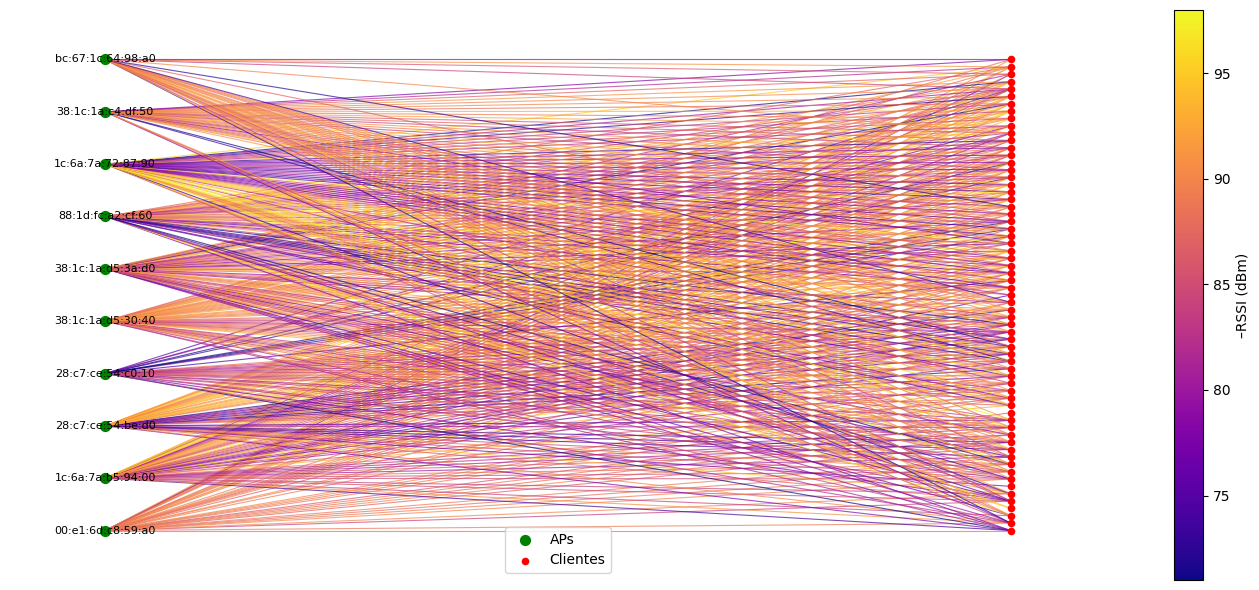

In [71]:
from networkx.drawing.layout import bipartite_layout

def simple_bipartite_plot(df, building_id, threshold=70, max_clients=200, max_aps=200):
    # 1) Filtrar
    df = (df[df.building_id == building_id]
            .query("BANDA==0 and RSSI< -@threshold"))
    ts = df.timestamp.min()
    df = df[df.timestamp == ts]

    # 2) Muestrear
    df = df[df.MAC_CLIENT.isin(df.MAC_CLIENT.unique()[:max_clients])]
    df = df[df.MAC_AP.isin(df.MAC_AP.unique()[:max_aps])]

    # 3) Construir grafo
    G = nx.Graph()
    G.add_nodes_from(df.MAC_AP.unique(), bipartite=0)
    G.add_nodes_from(df.MAC_CLIENT.unique(), bipartite=1)
    for c, a, r in df[['MAC_CLIENT', 'MAC_AP', 'RSSI']].itertuples(index=False):
        G.add_edge(a, c, rssi=-r)

    # 4) Dibujar
    aps = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    clients = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]
    pos = bipartite_layout(G, nodes=aps)
    edgelist = G.edges()
    weights = [G[u][v]['rssi'] for u, v in edgelist]
    cmap = plt.cm.plasma
    norm = plt.Normalize(min(weights), max(weights))

    fig, ax = plt.subplots(figsize=(14, 6))
    nx.draw_networkx_nodes(G, pos,
        nodelist=aps,
        node_color='green', node_size=50, label='APs', ax=ax)
    nx.draw_networkx_nodes(G, pos,
        nodelist=clients,
        node_color='red', node_size=20, label='Clientes', ax=ax)
    nx.draw_networkx_edges(G, pos,
        edge_color=weights, edge_cmap=cmap, edge_vmin=min(weights), edge_vmax=max(weights),
        width=0.8, alpha=0.7, ax=ax)

    # NUEVO: Agregar etiquetas a los APs
    ap_labels = {n: n for n in aps}
    nx.draw_networkx_labels(G, pos, labels=ap_labels, font_size=8, verticalalignment='center', ax=ax)

    ax.legend(scatterpoints=1)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='–RSSI (dBm)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Asegúrate de que df tenga ya columna `building_id` y `timestamp` tipo datetime
simple_bipartite_plot(
  df_merged,      # tu df_rssi con building_id
  building_id=994,  # edificio a visualizar
  threshold=70,   # -70 dBm
  max_clients=200,
  max_aps=200
)

## Representación más detallada del grafo con métricas

In [54]:
def advanced_metrics_plot(df, building_id, threshold=70, max_clients=200, max_aps=200):
    # 1. Filtrado y preparación
    df = (df[df.building_id == building_id]
          .query("BANDA==0 and RSSI< -@threshold"))
    ts = df.timestamp.min()
    df = df[df.timestamp == ts]
    df = df[df.MAC_CLIENT.isin(df.MAC_CLIENT.unique()[:max_clients])]
    df = df[df.MAC_AP.isin(df.MAC_AP.unique()[:max_aps])]

    # 2. Construcción del grafo
    G = nx.Graph()
    G.add_nodes_from(df.MAC_AP.unique(), bipartite='ap', type='ap')
    G.add_nodes_from(df.MAC_CLIENT.unique(), bipartite='client', type='client')
    for _, row in df.iterrows():
        G.add_edge(row['MAC_AP'], row['MAC_CLIENT'], rssi=-row['RSSI'])

    # 3. Métricas
    degree      = dict(G.degree())
    betweenness = nx.betweenness_centrality(G)
    try:
        coms = list(nx.community.greedy_modularity_communities(G))
        modularity = nx.community.modularity(G, coms)
    except:
        coms, modularity = [set(G.nodes())], 0

    # 4. Figura y ejes
    fig, (ax, ax_m) = plt.subplots(
        1, 2, figsize=(20, 8),
        gridspec_kw={'width_ratios': [3, 1.2]}
    )
    fig.suptitle(f"Análisis Avanzado de Red – Edificio {building_id}", fontsize=18, y=0.98)

    # 5. Colores y tamaños
    max_b = max(betweenness.values()) if betweenness else 1
    node_colors = []
    for n in G:
        b = betweenness[n]/max_b
        if G.nodes[n]['type']=='ap':
            node_colors.append((0, 0.7, 0, 0.5+0.5*b))
        else:
            node_colors.append((0.7, 0, 0, 0.3+0.7*b))
    node_sizes = [degree[n]*20 for n in G]

    # 6. Layout y dibujo del grafo
    pos = nx.spring_layout(G, k=0.3, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.2, edge_color='gray', ax=ax)
    ax.set_axis_off()

    # 7. Destacar top 5
    top5 = sorted(betweenness.items(), key=lambda x:x[1], reverse=True)[:5]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n,_ in top5],
        node_size=[degree[n]*30 for n,_ in top5],
        node_color='gold', edgecolors='darkorange', linewidths=1.5, ax=ax
    )

    # 8. Panel de métricas (fuente más grande)
    ax_m.axis('off')
    y = 0.95
    line_h = 0.07

    txt1 = textwrap.dedent(f"""
      Métricas Clave:
      • Nodos: {G.number_of_nodes()}
      • Enlaces: {G.number_of_edges()}
      • Densidad: {nx.density(G):.3f}
      • Modularidad: {modularity:.3f}
      • Componentes: {nx.number_connected_components(G)}
    """).strip()
    ax_m.text(0.05, y, txt1, fontsize=24, va='top')
    
    # Top APs (MAC completa)
    y -= line_h*6
    aps = [n for n,d in G.nodes(data=True) if d['type']=='ap']
    top_aps = sorted(aps, key=lambda n:degree[n], reverse=True)[:5]
    txt2 = "Top APs (grado):\n" + "\n".join(
        f"{i+1}. {ap}: {degree[ap]} "
        for i,ap in enumerate(top_aps)
    )
    ax_m.text(0.05, y, txt2, fontsize=22, va='top')

    # Top Clientes (MAC completa)
    y -= line_h*(len(top_aps)+2)
    clients = [n for n,d in G.nodes(data=True) if d['type']=='client']
    top_cl = sorted(clients, key=lambda n:degree[n], reverse=True)[:3]
    txt3 = "Top Clientes (grado):\n" + "\n".join(
        f"{i+1}. {cl}: {degree[cl]}"
        for i,cl in enumerate(top_cl)
    )
    ax_m.text(0.05, y, txt3, fontsize=22, va='top')

    # 9. Leyenda
    ax.legend(
        handles=[
            plt.Line2D([],[],marker='o', color='w', markerfacecolor='green', markersize=10, label='APs'),
            plt.Line2D([],[],marker='o', color='w', markerfacecolor='red', markersize=7,  label='Clientes'),
            plt.Line2D([],[],marker='o', color='w', markerfacecolor='gold', markersize=10, label='Nodos críticos')
        ],
        loc='lower left',
        fontsize=12
    )

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


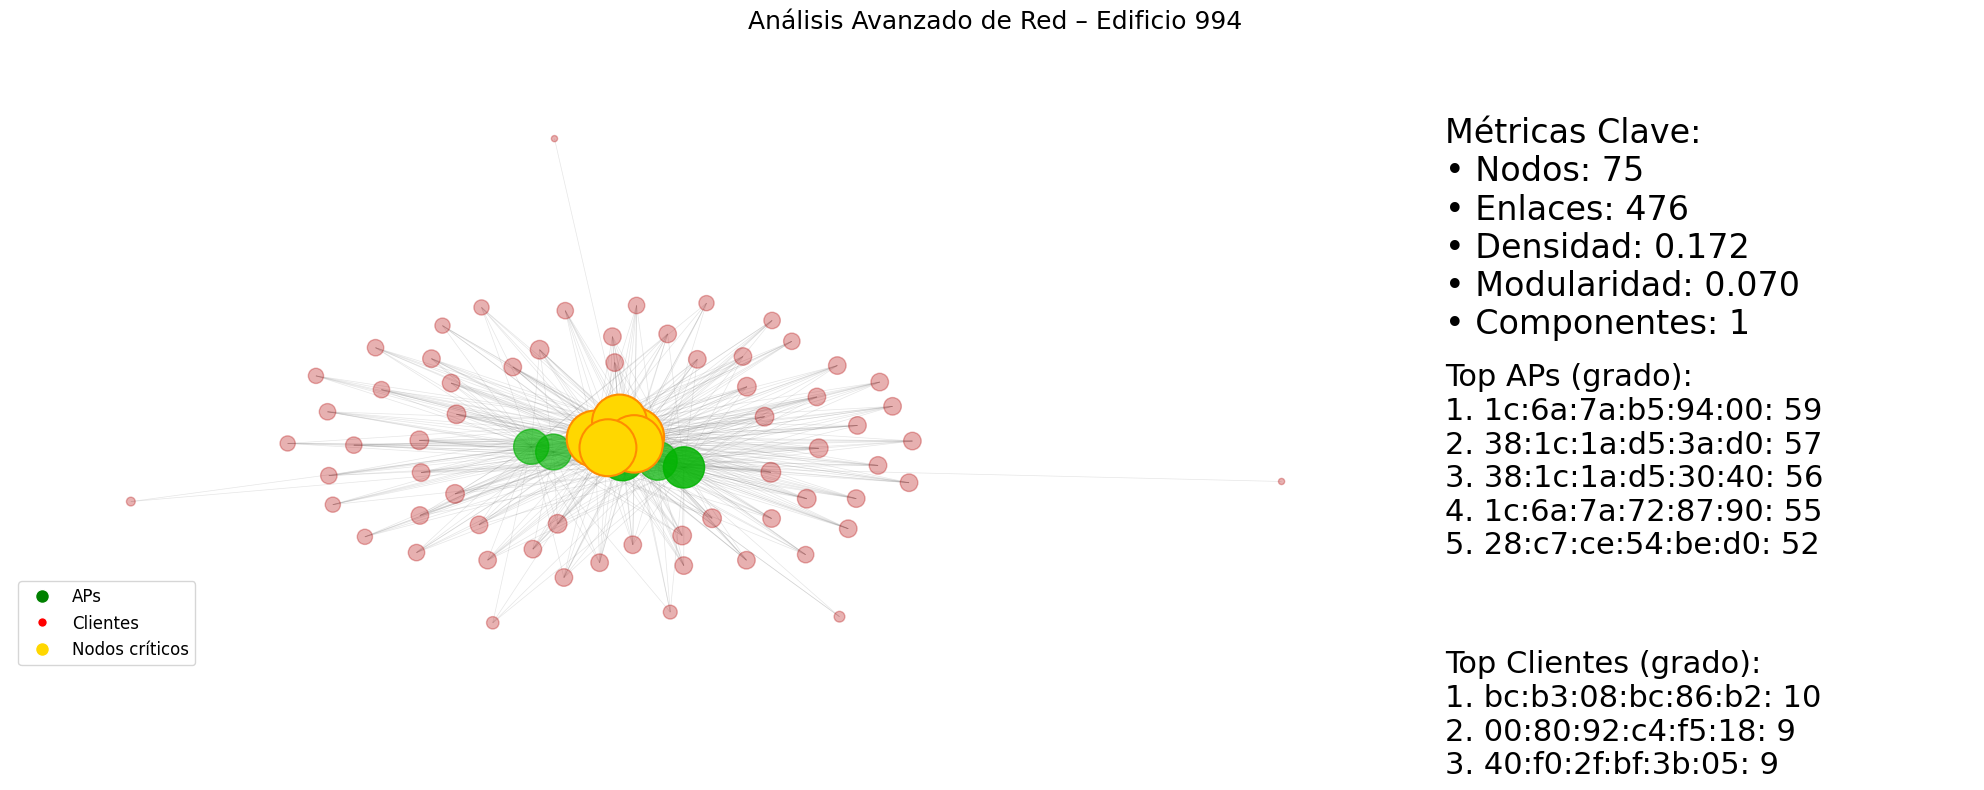

In [55]:
advanced_metrics_plot(
    df_rssi_with_building,
    building_id=994,       # Edificio a analizar
    threshold=70,        # Umbral de RSSI
    max_clients=200,     # Límite de clientes
    max_aps=200          # Límite de APs
)

## Creación de la tabla para cada AP

In [98]:
# Paso 1: Renombrar MAC_AP en df_asociacion para que quede claro que es el AP asociado
df_asociacion_ren = df_asociacion.rename(columns={'MAC_AP': 'AP_ASOCIADO'})

# Paso 2: Merge entre el RSSI y la info de asociación
df_check = df_rssi_with_building.merge(
    df_asociacion_ren[['MAC_CLIENT', 'timestamp', 'AP_ASOCIADO']],
    on=['MAC_CLIENT', 'timestamp'],
    how='left'
)

# Paso 3: Para cada cliente en cada timestamp, obtener el AP con mayor RSSI
# Primero ordenamos para quedarnos con el AP con mayor RSSI por cliente/timestamp
df_check['RSSI'] = df_check['RSSI'].astype(float)  # por si viene como string
df_check_sorted = df_check.sort_values(by=['MAC_CLIENT', 'timestamp', 'RSSI'], ascending=[True, True, False])

# Obtenemos el mejor AP (con más RSSI) para cada cliente en ese momento
best_ap = df_check_sorted.groupby(['MAC_CLIENT', 'timestamp']).first().reset_index()
best_ap = best_ap.rename(columns={'MAC_AP': 'AP_CON_MEJOR_RSSI'})

# Paso 4: Volvemos a unir para comparar con el AP asociado
df_resultado = df_asociacion_ren.merge(
    best_ap[['MAC_CLIENT', 'timestamp', 'AP_CON_MEJOR_RSSI']],
    on=['MAC_CLIENT', 'timestamp'],
    how='left'
)

# Paso 5: Chequeamos si el AP asociado es el mismo que el de mejor señal
df_resultado['es_mejor_ap'] = df_resultado['AP_ASOCIADO'].str.lower() == df_resultado['AP_CON_MEJOR_RSSI'].str.lower()

# Resultado
df_resultado[['MAC_CLIENT', 'timestamp', 'AP_ASOCIADO', 'AP_CON_MEJOR_RSSI', 'es_mejor_ap']].head()


,MAC_CLIENT,timestamp,AP_ASOCIADO,AP_CON_MEJOR_RSSI,es_mejor_ap
0,00:00:06:6d:06:21,2018-07-27 11:05,1c:6a:7a:b5:85:e0,1c:6a:7a:b5:85:e0,True
1,00:00:06:6d:2c:ed,2018-07-27 11:05,18:8b:9d:83:2d:d0,18:8b:9d:7d:7a:e0,False
2,00:00:06:ae:f1:b2,2018-07-27 11:05,18:8b:9d:6e:a1:c0,18:8b:9d:6e:a1:c0,True
3,00:00:06:af:16:a8,2018-07-27 11:05,00:42:68:d6:06:20,NaN,False
4,00:00:08:a4:95:aa,2018-07-27 11:05,18:8b:9d:36:75:00,18:8b:9d:36:75:00,True


In [99]:
# Porcentaje de clientes que están conectados al mejor AP
porcentaje_correcto = df_resultado['es_mejor_ap'].mean() * 100
print(f"Porcentaje de clientes conectados al AP con mejor RSSI: {porcentaje_correcto:.2f}%")

Porcentaje de clientes conectados al AP con mejor RSSI: 51.82%


## Anális por banda:

In [ ]:
# Paso 1: Renombramos para claridad
df_asociacion_ren = df_asociacion.rename(columns={'MAC_AP': 'AP_ASOCIADO'})

# Paso 2: Merge entre df_merged y asociación
df_check = df_merged.merge(
    df_asociacion_ren[['MAC_CLIENT', 'timestamp', 'AP_ASOCIADO']],
    on=['MAC_CLIENT', 'timestamp'],
    how='left'
)

# Paso 3: Obtener el AP con mejor RSSI por cliente y timestamp
df_check['RSSI'] = df_check['RSSI'].astype(float)
df_sorted = df_check.sort_values(by=['MAC_CLIENT', 'timestamp', 'RSSI'], ascending=[True, True, False])
best_rssi = df_sorted.groupby(['MAC_CLIENT', 'timestamp']).first().reset_index()
best_rssi = best_rssi.rename(columns={'MAC_AP': 'AP_CON_MEJOR_RSSI', 'BANDA': 'BANDA_CON_MEJOR_RSSI'})

# Paso 4: Obtener la banda del AP asociado a partir de df_merged
df_banda_asociada = df_merged.merge(
    df_asociacion_ren,
    left_on=['MAC_CLIENT', 'timestamp', 'MAC_AP'],
    right_on=['MAC_CLIENT', 'timestamp', 'AP_ASOCIADO'],
    how='inner'
)
df_banda_asociada = df_banda_asociada[['MAC_CLIENT', 'timestamp', 'AP_ASOCIADO', 'BANDA']].drop_duplicates()
df_banda_asociada = df_banda_asociada.rename(columns={'BANDA': 'BANDA_ASOCIADA'})

# Paso 5: Merge para comparar
df_resultado = df_asociacion_ren.merge(best_rssi[['MAC_CLIENT', 'timestamp', 'AP_CON_MEJOR_RSSI', 'BANDA_CON_MEJOR_RSSI']],
                                       on=['MAC_CLIENT', 'timestamp'], how='left')

df_resultado = df_resultado.merge(df_banda_asociada,
                                  on=['MAC_CLIENT', 'timestamp', 'AP_ASOCIADO'], how='left')

# Paso 6: Comparar si se conectó a la mejor banda
df_resultado['se_conecto_a_mejor_banda'] = df_resultado['BANDA_ASOCIADA'] == df_resultado['BANDA_CON_MEJOR_RSSI']

# Resultado final
df_resultado[['MAC_CLIENT', 'timestamp', 'AP_ASOCIADO', 'BANDA_ASOCIADA', 'BANDA_CON_MEJOR_RSSI', 'se_conecto_a_mejor_banda']].head()


,MAC_CLIENT,timestamp,AP_ASOCIADO,BANDA_ASOCIADA,BANDA_CON_MEJOR_RSSI,se_conecto_a_mejor_banda
0,00:00:06:6d:06:21,2018-07-27 11:05,1c:6a:7a:b5:85:e0,0.0,0.0,True
1,00:00:06:6d:2c:ed,2018-07-27 11:05,18:8b:9d:83:2d:d0,0.0,0.0,True
2,00:00:06:ae:f1:b2,2018-07-27 11:05,18:8b:9d:6e:a1:c0,0.0,0.0,True
3,00:00:06:af:16:a8,2018-07-27 11:05,00:42:68:d6:06:20,NaN,NaN,False
4,00:00:08:a4:95:aa,2018-07-27 11:05,18:8b:9d:36:75:00,0.0,0.0,True


In [105]:
# Eliminamos los casos donde falte alguna banda
df_resultado_filtrado = df_resultado.dropna(subset=['BANDA_ASOCIADA', 'BANDA_CON_MEJOR_RSSI'])

# Porcentaje de veces que se conectó a la mejor banda
porcentaje_mejor_banda = df_resultado_filtrado['se_conecto_a_mejor_banda'].mean() * 100

print(f"Se conectó a la mejor banda el {porcentaje_mejor_banda:.2f}% de las veces")


Se conectó a la mejor banda el 72.56% de las veces


## Bulk archivos 

In [10]:
import re
import tarfile
import pandas as pd
import glob

def extraer_mac(numeros):
    """Convierte lista de strings con números decimales a MAC en formato hexadecimal."""
    return ':'.join(f'{int(n):02x}' for n in numeros)

def procesar_archivo_tgz(archivo_tgz):
    """Procesa un archivo .tgz y extrae datos de RSSI y ASOCIACION"""
    # Extraer timestamp del nombre del archivo tgz
    match_ts = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}_\d{2})', archivo_tgz)
    timestamp_archivo = pd.to_datetime(match_ts.group(1), format='%Y-%m-%d_%H_%M') if match_ts else None
    
    datos_rssi = []
    datos_asociacion = []
    
    with tarfile.open(archivo_tgz, 'r:gz') as tar:
        for nombre in tar.getnames():
            # Procesar archivos de RSSI
            if 'datos_RSSI' in nombre:
                wlc_match = re.search(r'(WLC\d+)', nombre)
                wlc_id = wlc_match.group(1) if wlc_match else None

                miembro = tar.getmember(nombre)
                f = tar.extractfile(miembro)
                if f is None:
                    continue

                for linea in f:
                    linea = linea.decode('utf-8').strip()
                    match = re.search(r'1\.5\.(.*?) = INTEGER: (-?\d+)', linea)
                    if not match:
                        continue

                    partes_oid = match.group(1).split('.')
                    if len(partes_oid) < 12:
                        continue

                    mac_cliente = extraer_mac(partes_oid[0:6])
                    mac_ap = extraer_mac(partes_oid[6:12])
                    banda = int(partes_oid[12]) if len(partes_oid) > 12 else None
                    antena = int(partes_oid[13]) if len(partes_oid) > 13 else None
                    rssi = int(match.group(2))

                    datos_rssi.append({
                        'MAC_CLIENT': mac_cliente.lower(),
                        'MAC_AP': mac_ap.lower(),
                        'BANDA': banda,
                        'ANTENA': antena,
                        'RSSI': rssi,
                        'WLC': wlc_id,
                        'timestamp': timestamp_archivo
                    })
            
            # Procesar archivos de ASOCIACION
            elif 'datos_ASOCIACION' in nombre:
                wlc_match = re.search(r'(WLC\d+)', nombre)
                wlc_id = wlc_match.group(1) if wlc_match else None

                miembro = tar.getmember(nombre)
                f = tar.extractfile(miembro)
                if f is None:
                    continue

                for linea in f:
                    linea = linea.decode('utf-8').strip()
                    match = re.search(r'\.4\.1\.4\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.(\d+) = Hex-STRING: ([0-9A-Fa-f ]+)', linea)
                    if not match:
                        continue
                        
                    mac_cliente = extraer_mac(match.groups()[:6])
                    mac_ap_hex = match.group(7).replace(' ', '')
                    mac_ap = ':'.join([mac_ap_hex[i:i+2] for i in range(0, 12, 2)]).lower()
                    
                    datos_asociacion.append({
                        'MAC_CLIENT': mac_cliente.lower(),
                        'MAC_AP': mac_ap.lower(),
                        'WLC': wlc_id,
                        'timestamp': timestamp_archivo
                    })
    
    # Crear DataFrames
    df_rssi = pd.DataFrame(datos_rssi)
    if not df_rssi.empty:
        df_rssi['timestamp'] = df_rssi['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    df_asociacion = pd.DataFrame(datos_asociacion)
    if not df_asociacion.empty:
        df_asociacion['timestamp'] = df_asociacion['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    return df_rssi, df_asociacion

def analizar_mejor_ap(df_rssi, df_asociacion):
    """Realiza el análisis de comparación entre AP asociado y AP con mejor RSSI"""
    if df_rssi.empty or df_asociacion.empty:
        return None, None
    
    # Paso 1: Renombrar MAC_AP en df_asociacion
    df_asociacion_ren = df_asociacion.rename(columns={'MAC_AP': 'AP_ASOCIADO'})
    
    # Paso 2: Merge entre RSSI y asociación
    df_check = df_rssi.merge(
        df_asociacion_ren[['MAC_CLIENT', 'timestamp', 'AP_ASOCIADO']],
        on=['MAC_CLIENT', 'timestamp'],
        how='left'
    )
    
    # Paso 3: Obtener el AP con mayor RSSI por cliente/timestamp
    df_check['RSSI'] = df_check['RSSI'].astype(float)
    df_check_sorted = df_check.sort_values(by=['MAC_CLIENT', 'timestamp', 'RSSI'], 
                                         ascending=[True, True, False])
    
    best_ap = df_check_sorted.groupby(['MAC_CLIENT', 'timestamp']).first().reset_index()
    best_ap = best_ap.rename(columns={'MAC_AP': 'AP_CON_MEJOR_RSSI'})
    
    # Paso 4: Unir con datos de asociación
    df_resultado = df_asociacion_ren.merge(
        best_ap[['MAC_CLIENT', 'timestamp', 'AP_CON_MEJOR_RSSI']],
        on=['MAC_CLIENT', 'timestamp'],
        how='left'
    )
    
    # Paso 5: Comparar AP asociado con el de mejor señal
    df_resultado['es_mejor_ap'] = df_resultado['AP_ASOCIADO'].str.lower() == df_resultado['AP_CON_MEJOR_RSSI'].str.lower()
    
    # Calcular porcentaje
    porcentaje_correcto = df_resultado['es_mejor_ap'].mean() * 100
    
    return df_resultado, porcentaje_correcto

In [17]:
import random
# Procesar múltiples archivos y guardar resultados
archivos_tgz = random.sample(glob.glob('../datos_ceibal/datos_ceibal_clientes/RSSI_WLCs_*.tgz'),20)
resultados_por_archivo = []

for archivo in archivos_tgz:
    # print(f"Procesando archivo: {archivo}")
    df_rssi, df_asociacion = procesar_archivo_tgz(archivo)
    
    if not df_rssi.empty and not df_asociacion.empty:
        df_resultado, porcentaje = analizar_mejor_ap(df_rssi, df_asociacion)
        
        if porcentaje is not None:
            # Extraer fecha del nombre del archivo
            fecha = re.search(r'(\d{4}-\d{2}-\d{2})', archivo).group(1)
            resultados_por_archivo.append({
                'archivo': archivo,
                'fecha': fecha,
                'porcentaje_mejor_ap': porcentaje,
                'clientes_totales': len(df_resultado),
                'clientes_correctos': df_resultado['es_mejor_ap'].sum()
            })
            
            # print(f"  Porcentaje conectados al mejor AP: {porcentaje:.2f}%")
        else:
            print("  No se pudo realizar el análisis (datos insuficientes)")
    else:
        print("  Archivo sin datos suficientes para análisis")

# Crear DataFrame con resultados
if resultados_por_archivo:
    df_resultados = pd.DataFrame(resultados_por_archivo)
    # print("\nResumen de resultados:")
    # print(df_resultados[['fecha', 'porcentaje_mejor_ap', 'clientes_totales', 'clientes_correctos']])
    
    # Calcular promedio general
    promedio_general = df_resultados['porcentaje_mejor_ap'].mean()
    # print(f"\nPorcentaje promedio general: {promedio_general:.2f}%")

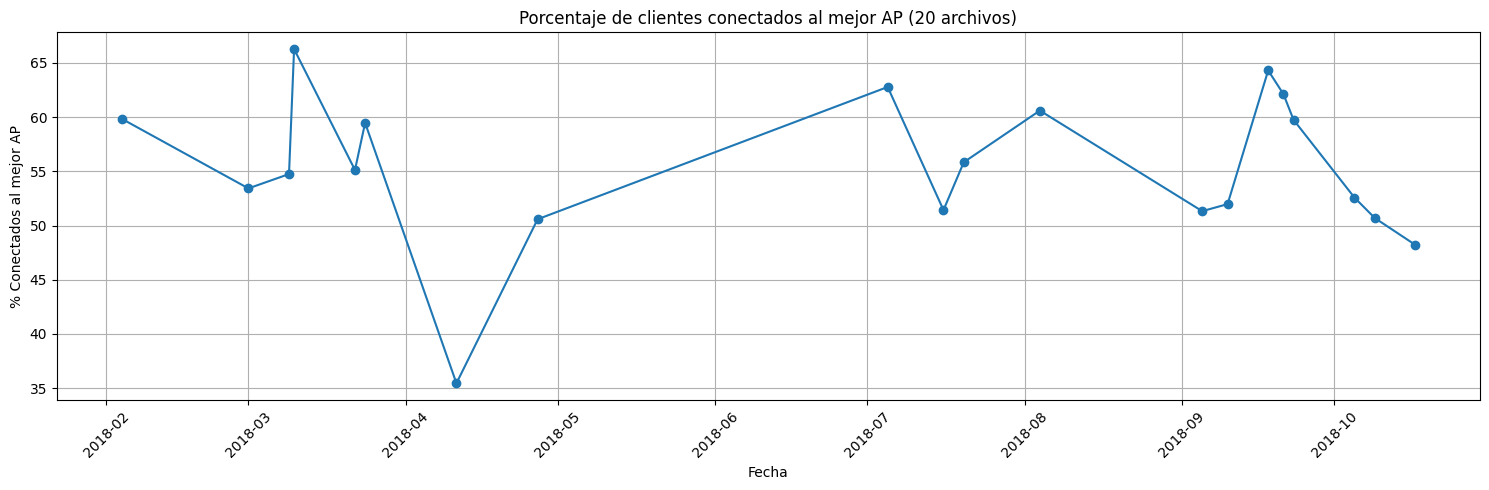

In [18]:
import matplotlib.pyplot as plt

# Asegurate de tener el DataFrame ordenado por fecha
df_resultados['fecha'] = pd.to_datetime(df_resultados['fecha'])
df_resultados = df_resultados.sort_values(by='fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_resultados['fecha'], df_resultados['porcentaje_mejor_ap'], marker='o', linestyle='-')
plt.title('Porcentaje de clientes conectados al mejor AP (20 archivos)')
plt.xlabel('Fecha')
plt.ylabel('% Conectados al mejor AP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


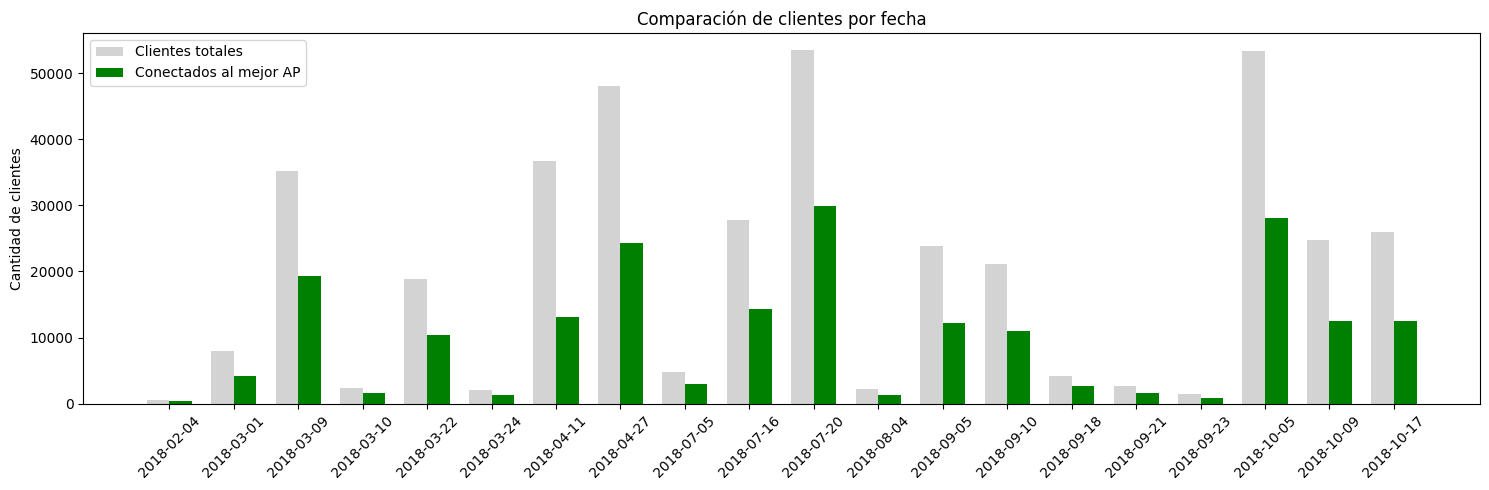

In [20]:
import numpy as np

x = np.arange(len(df_resultados))
width = 0.35

plt.figure(figsize=(15, 5))
plt.bar(x - width/2, df_resultados['clientes_totales'], width, label='Clientes totales', color='lightgray')
plt.bar(x + width/2, df_resultados['clientes_correctos'], width, label='Conectados al mejor AP', color='green')

plt.xticks(x, df_resultados['fecha'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.ylabel('Cantidad de clientes')
plt.title('Comparación de clientes por fecha')
plt.legend()
plt.tight_layout()
plt.show()
